# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

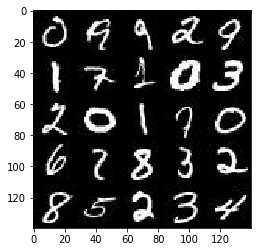

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

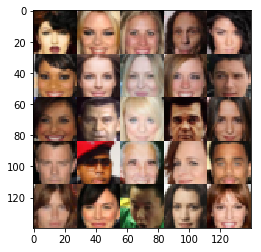

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels),name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        # x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        #logits = tf.slice(logits, [0, 2, 2, 0], [-1, 28, 28, -1])
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))             
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.4565... Generator Loss: 12.7825
Epoch 0/2... Discriminator Loss: 1.3064... Generator Loss: 0.3512
Epoch 0/2... Discriminator Loss: 0.1096... Generator Loss: 8.7936
Epoch 0/2... Discriminator Loss: 0.5866... Generator Loss: 0.8798


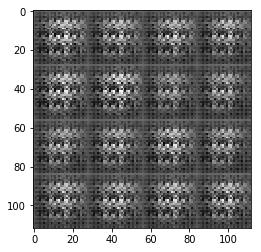

Epoch 0/2... Discriminator Loss: 0.2370... Generator Loss: 10.3961
Epoch 0/2... Discriminator Loss: 0.2474... Generator Loss: 3.9799
Epoch 0/2... Discriminator Loss: 0.2377... Generator Loss: 3.8911
Epoch 0/2... Discriminator Loss: 0.4647... Generator Loss: 2.0286
Epoch 0/2... Discriminator Loss: 1.2909... Generator Loss: 1.0537


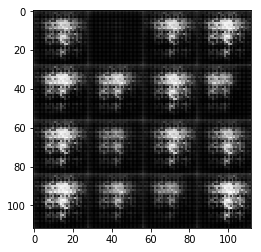

Epoch 0/2... Discriminator Loss: 0.2613... Generator Loss: 2.3860
Epoch 0/2... Discriminator Loss: 0.1577... Generator Loss: 4.7474
Epoch 0/2... Discriminator Loss: 0.4130... Generator Loss: 1.8717
Epoch 0/2... Discriminator Loss: 0.2267... Generator Loss: 2.4731
Epoch 0/2... Discriminator Loss: 0.3081... Generator Loss: 2.1643


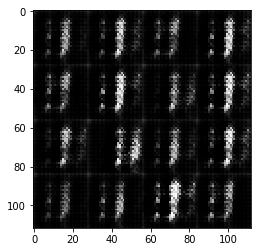

Epoch 0/2... Discriminator Loss: 0.3755... Generator Loss: 14.1565
Epoch 0/2... Discriminator Loss: 0.4737... Generator Loss: 4.4481
Epoch 0/2... Discriminator Loss: 0.1846... Generator Loss: 3.7677
Epoch 0/2... Discriminator Loss: 0.2348... Generator Loss: 3.2008
Epoch 0/2... Discriminator Loss: 0.2158... Generator Loss: 2.3539


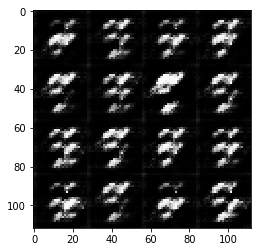

Epoch 0/2... Discriminator Loss: 0.2289... Generator Loss: 5.4763
Epoch 0/2... Discriminator Loss: 0.3742... Generator Loss: 5.5937
Epoch 0/2... Discriminator Loss: 0.1801... Generator Loss: 2.7043
Epoch 0/2... Discriminator Loss: 0.2661... Generator Loss: 1.9783
Epoch 0/2... Discriminator Loss: 0.1519... Generator Loss: 2.9717


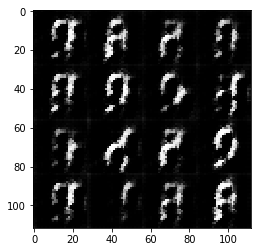

Epoch 0/2... Discriminator Loss: 0.0954... Generator Loss: 3.8666
Epoch 0/2... Discriminator Loss: 0.2030... Generator Loss: 2.8451
Epoch 0/2... Discriminator Loss: 0.1721... Generator Loss: 3.6176
Epoch 0/2... Discriminator Loss: 0.2888... Generator Loss: 3.5974
Epoch 0/2... Discriminator Loss: 0.3996... Generator Loss: 3.5749


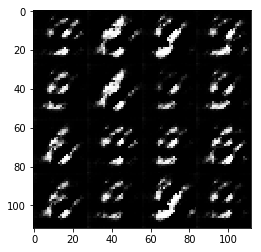

Epoch 0/2... Discriminator Loss: 0.2485... Generator Loss: 2.5699
Epoch 0/2... Discriminator Loss: 0.1857... Generator Loss: 2.8021
Epoch 0/2... Discriminator Loss: 0.2115... Generator Loss: 3.0529
Epoch 0/2... Discriminator Loss: 0.2117... Generator Loss: 2.4353
Epoch 0/2... Discriminator Loss: 0.1797... Generator Loss: 2.9410


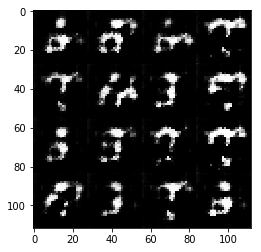

Epoch 0/2... Discriminator Loss: 0.1783... Generator Loss: 2.8256
Epoch 0/2... Discriminator Loss: 0.3201... Generator Loss: 2.5180
Epoch 0/2... Discriminator Loss: 0.1833... Generator Loss: 3.8488
Epoch 0/2... Discriminator Loss: 0.1911... Generator Loss: 3.1077
Epoch 0/2... Discriminator Loss: 1.9167... Generator Loss: 0.2679


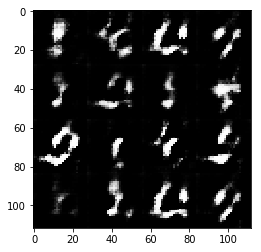

Epoch 0/2... Discriminator Loss: 0.6149... Generator Loss: 5.3568
Epoch 0/2... Discriminator Loss: 0.4380... Generator Loss: 3.0002
Epoch 0/2... Discriminator Loss: 0.5184... Generator Loss: 1.5591
Epoch 0/2... Discriminator Loss: 0.7344... Generator Loss: 6.0138
Epoch 0/2... Discriminator Loss: 0.3818... Generator Loss: 3.1467


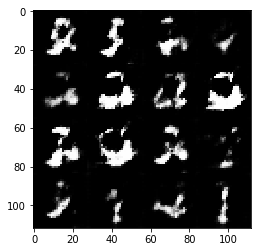

Epoch 0/2... Discriminator Loss: 0.3296... Generator Loss: 2.5733
Epoch 0/2... Discriminator Loss: 0.6648... Generator Loss: 1.5503
Epoch 0/2... Discriminator Loss: 0.4003... Generator Loss: 2.3619
Epoch 0/2... Discriminator Loss: 0.5373... Generator Loss: 1.8148
Epoch 0/2... Discriminator Loss: 0.2787... Generator Loss: 2.1977


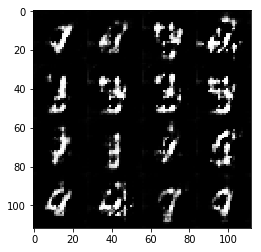

Epoch 0/2... Discriminator Loss: 0.1780... Generator Loss: 3.6399
Epoch 0/2... Discriminator Loss: 0.5138... Generator Loss: 2.1955
Epoch 0/2... Discriminator Loss: 0.3466... Generator Loss: 1.9496
Epoch 0/2... Discriminator Loss: 0.4919... Generator Loss: 1.7714
Epoch 0/2... Discriminator Loss: 0.5565... Generator Loss: 1.4368


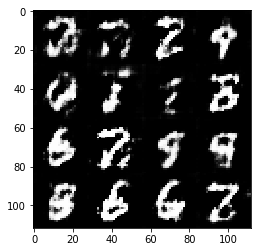

Epoch 0/2... Discriminator Loss: 0.3570... Generator Loss: 2.0860
Epoch 0/2... Discriminator Loss: 0.6013... Generator Loss: 1.4851
Epoch 0/2... Discriminator Loss: 0.5630... Generator Loss: 2.1728
Epoch 0/2... Discriminator Loss: 0.3701... Generator Loss: 2.0638
Epoch 0/2... Discriminator Loss: 0.5859... Generator Loss: 1.4232


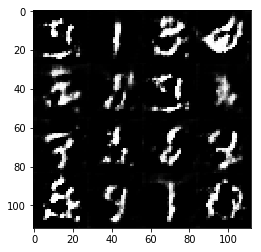

Epoch 0/2... Discriminator Loss: 0.5675... Generator Loss: 4.1938
Epoch 0/2... Discriminator Loss: 0.3532... Generator Loss: 2.1054
Epoch 0/2... Discriminator Loss: 0.5384... Generator Loss: 1.8989
Epoch 0/2... Discriminator Loss: 0.6086... Generator Loss: 2.6384
Epoch 0/2... Discriminator Loss: 0.5383... Generator Loss: 1.9843


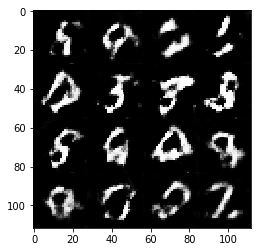

Epoch 0/2... Discriminator Loss: 0.5966... Generator Loss: 1.4051
Epoch 0/2... Discriminator Loss: 0.4717... Generator Loss: 1.9635
Epoch 0/2... Discriminator Loss: 0.5227... Generator Loss: 2.2972
Epoch 0/2... Discriminator Loss: 1.5546... Generator Loss: 0.4556
Epoch 0/2... Discriminator Loss: 0.8464... Generator Loss: 0.8289


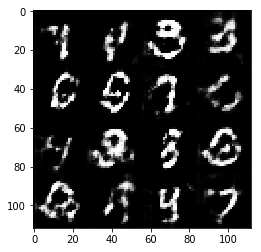

Epoch 0/2... Discriminator Loss: 0.8760... Generator Loss: 0.9039
Epoch 0/2... Discriminator Loss: 0.6470... Generator Loss: 1.5726
Epoch 0/2... Discriminator Loss: 0.5578... Generator Loss: 1.8950
Epoch 0/2... Discriminator Loss: 0.8389... Generator Loss: 1.0083
Epoch 0/2... Discriminator Loss: 0.8609... Generator Loss: 2.1669


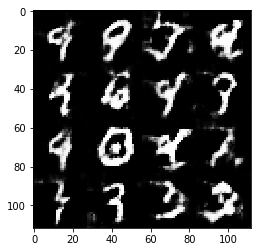

Epoch 0/2... Discriminator Loss: 0.6086... Generator Loss: 1.6777
Epoch 0/2... Discriminator Loss: 0.8485... Generator Loss: 0.8462
Epoch 0/2... Discriminator Loss: 0.5320... Generator Loss: 1.3567
Epoch 0/2... Discriminator Loss: 1.1687... Generator Loss: 0.5779
Epoch 0/2... Discriminator Loss: 0.6468... Generator Loss: 1.6601


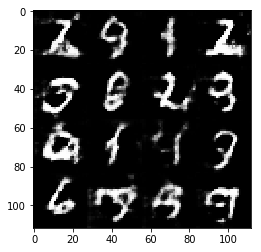

Epoch 0/2... Discriminator Loss: 1.0093... Generator Loss: 0.8022
Epoch 0/2... Discriminator Loss: 0.6194... Generator Loss: 1.5948
Epoch 0/2... Discriminator Loss: 0.5472... Generator Loss: 1.8487
Epoch 0/2... Discriminator Loss: 0.8070... Generator Loss: 1.0409
Epoch 0/2... Discriminator Loss: 0.7507... Generator Loss: 1.0811


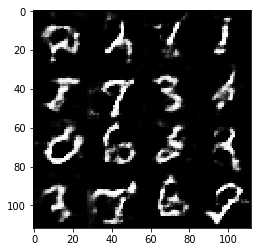

Epoch 0/2... Discriminator Loss: 1.0601... Generator Loss: 0.8079
Epoch 0/2... Discriminator Loss: 0.6794... Generator Loss: 1.3208
Epoch 0/2... Discriminator Loss: 0.5733... Generator Loss: 1.9993
Epoch 0/2... Discriminator Loss: 0.7260... Generator Loss: 1.9119
Epoch 0/2... Discriminator Loss: 1.4717... Generator Loss: 0.4663


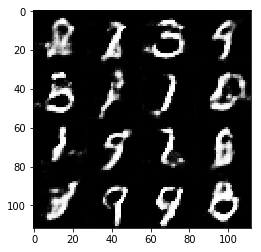

Epoch 0/2... Discriminator Loss: 0.9120... Generator Loss: 0.7924
Epoch 0/2... Discriminator Loss: 0.7069... Generator Loss: 1.5258
Epoch 0/2... Discriminator Loss: 0.6527... Generator Loss: 2.5839
Epoch 0/2... Discriminator Loss: 1.1075... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 2.2606


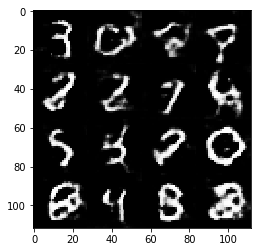

Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.9767
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.6147
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 2.9723
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.7492
Epoch 1/2... Discriminator Loss: 0.6664... Generator Loss: 2.0430


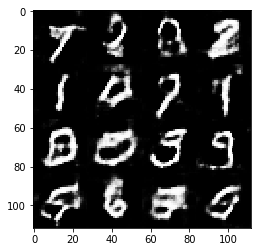

Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.7667
Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.0457
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.2588
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.2975


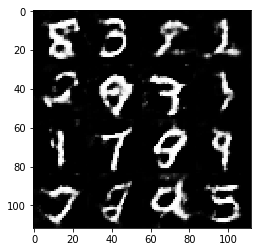

Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 0.9220... Generator Loss: 2.1556
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.7152
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 0.8990


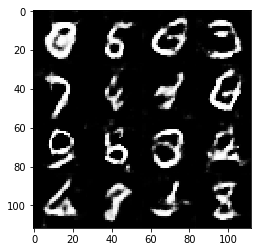

Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 0.9306
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.0323
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 0.7775


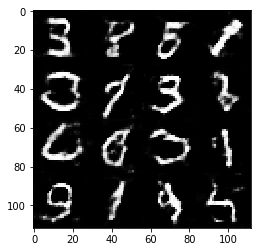

Epoch 1/2... Discriminator Loss: 0.6930... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 1.1605
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 3.1878
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.4621
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 1.3599


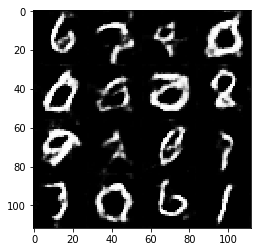

Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.6323
Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.5745
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.3375
Epoch 1/2... Discriminator Loss: 0.8378... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.2956


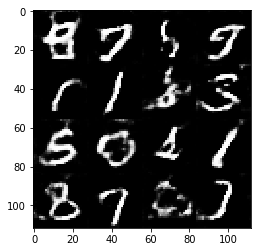

Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 1.8048
Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 1.4170
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 2.1023
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 1.0826
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 0.6839


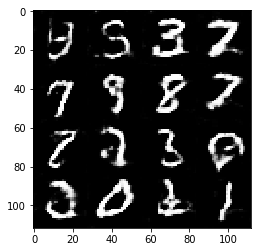

Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.2004
Epoch 1/2... Discriminator Loss: 1.5632... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.4347
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.5591


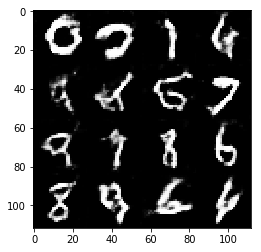

Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.0790
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 1.6631
Epoch 1/2... Discriminator Loss: 0.6010... Generator Loss: 1.4553


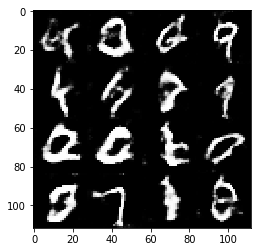

Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 2.5783... Generator Loss: 4.0799
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.2658


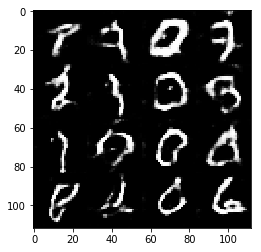

Epoch 1/2... Discriminator Loss: 0.6769... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 1.3004
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 0.7211... Generator Loss: 1.8275
Epoch 1/2... Discriminator Loss: 1.7310... Generator Loss: 0.3536


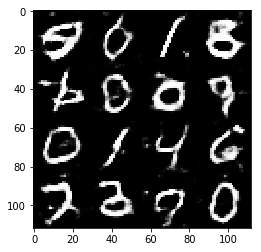

Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.6480
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.2144
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.4875


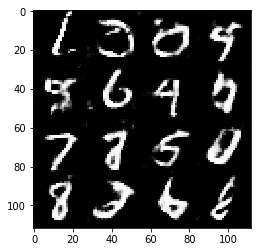

Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.3483


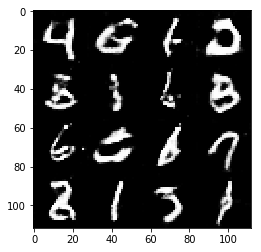

Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 0.7040... Generator Loss: 1.3043
Epoch 1/2... Discriminator Loss: 0.5393... Generator Loss: 1.3616
Epoch 1/2... Discriminator Loss: 0.4968... Generator Loss: 1.5386


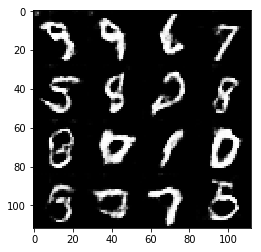

Epoch 1/2... Discriminator Loss: 0.5346... Generator Loss: 1.2480
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.6061
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.3186
Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 1.2244


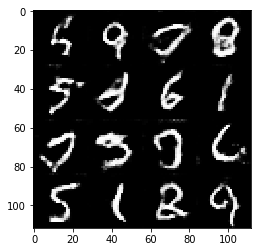

Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 1.1364
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.5941... Generator Loss: 0.3202
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 0.9689


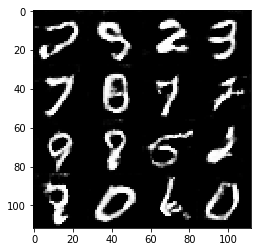

Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 1.9527
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.9773
Epoch 1/2... Discriminator Loss: 1.5747... Generator Loss: 3.7066
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 0.7865


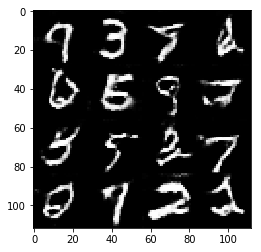

Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 0.7765... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.1451


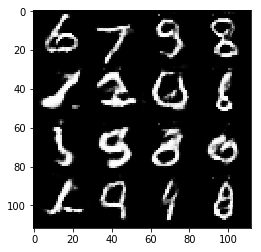

Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.0726
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 0.7438


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.2876... Generator Loss: 3.2832
Epoch 0/1... Discriminator Loss: 0.3076... Generator Loss: 1.6068
Epoch 0/1... Discriminator Loss: 0.0489... Generator Loss: 4.6916
Epoch 0/1... Discriminator Loss: 0.0513... Generator Loss: 8.0516


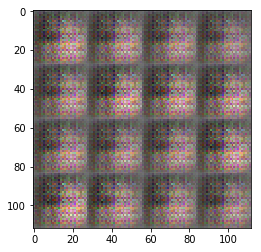

Epoch 0/1... Discriminator Loss: 2.0200... Generator Loss: 0.1631
Epoch 0/1... Discriminator Loss: 0.3363... Generator Loss: 3.8149
Epoch 0/1... Discriminator Loss: 0.5194... Generator Loss: 1.3254
Epoch 0/1... Discriminator Loss: 2.0520... Generator Loss: 0.2381
Epoch 0/1... Discriminator Loss: 0.1916... Generator Loss: 4.0412


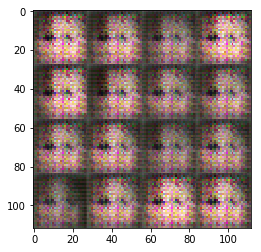

Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 5.1209
Epoch 0/1... Discriminator Loss: 0.3600... Generator Loss: 2.1076
Epoch 0/1... Discriminator Loss: 1.0428... Generator Loss: 0.7235


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.